In [2]:
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov

## Define parameters

In [3]:
omega_q = 1.0  # qubit level splitting
omega_T = 3.0  # TLS level splitting
J = 0.1  # qubit-TLS coupling
kappa = 0.04  # TLS decay rate
beta = 1.0  # inverse bath temperature
T = 25.0  # final time
nt = 2500  # number of time steps

## Define the Liouvillian

In [4]:
def liouvillian(omega_q, omega_T, J, kappa, beta):
    """Liouvillian for the coupled system of qubit and TLS"""

    # drift qubit Hamiltonian
    H0_q = 0.5 * omega_q * np.diag([-1, 1])
    # drive qubit Hamiltonian
    H1_q = 0.5 * np.diag([-1, 1])

    # drift TLS Hamiltonian
    H0_T = 0.5 * omega_T * np.diag([-1, 1])

    # Lift Hamiltonians to joint system operators
    H0 = np.kron(H0_q, np.identity(2)) + np.kron(np.identity(2), H0_T)
    H1 = np.kron(H1_q, np.identity(2))

    # qubit-TLS interaction
    H_int = J * np.fliplr(np.diag([0, 1, 1, 0]))

    # convert Hamiltonians to QuTiP objects
    H0 = qutip.Qobj(H0 + H_int)
    H1 = qutip.Qobj(H1)

    # Define Lindblad operators
    N = 1.0 / (np.exp(beta * omega_T) - 1.0)
    # Cooling on TLS
    L1 = np.sqrt(kappa * (N + 1)) * np.kron(
        np.identity(2), np.array([[0, 1], [0, 0]])
    )
    # Heating on TLS
    L2 = np.sqrt(kappa * N) * np.kron(
        np.identity(2), np.array([[0, 0], [1, 0]])
    )

    # convert Lindblad operators to QuTiP objects
    L1 = qutip.Qobj(L1)
    L2 = qutip.Qobj(L2)

    # generate the Liouvillian
    L0 = qutip.liouvillian(H=H0, c_ops=[L1, L2])
    L1 = qutip.liouvillian(H=H1)

    # Shift the qubit and TLS into resonance by default
    eps0 = lambda t, args: omega_T - omega_q

    return [L0, [L1, eps0]]


L = liouvillian(omega_q=omega_q, omega_T=omega_T, J=J, kappa=kappa, beta=beta)

In [50]:
H0_q = 0.5 * omega_q * np.diag([-1, 1])
H0_q

array([[-0.5,  0. ],
       [ 0. ,  0.5]])

In [52]:
qutip.liouvillian(qutip.Qobj(H0_q))

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = False
Qobj data =
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+1.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

In [49]:
L[1][1]

<function __main__.shape_field.<locals>.<lambda>(t, args)>

## Define optimization target

In [8]:
x_q = omega_q * beta / 2.0
rho_q_th = np.diag([np.exp(x_q), np.exp(-x_q)]) / (2 * np.cosh(x_q))

x_T = omega_T * beta / 2.0
rho_T_th = np.diag([np.exp(x_T), np.exp(-x_T)]) / (2 * np.cosh(x_T))

rho_th = qutip.Qobj(np.kron(rho_q_th, rho_T_th))


In [9]:
def trace_TLS(rho):
    """Partial trace over the TLS degrees of freedom"""
    rho_q = np.zeros(shape=(2, 2), dtype=np.complex_)
    rho_q[0, 0] = rho[0, 0] + rho[1, 1]
    rho_q[0, 1] = rho[0, 2] + rho[1, 3]
    rho_q[1, 0] = rho[2, 0] + rho[3, 1]
    rho_q[1, 1] = rho[2, 2] + rho[3, 3]
    return qutip.Qobj(rho_q)


In [10]:
rho_q_trg = np.diag([1, 0])
rho_T_trg = np.diag([1, 0])
rho_trg = np.kron(rho_q_trg, rho_T_trg)
rho_trg = qutip.Qobj(rho_trg)

In [11]:
objectives = [krotov.Objective(initial_state=rho_th, target=rho_trg, H=L)]
objectives

[Objective[ρ₀[4,4] to ρ₁[4,4] via [𝓛₀[[4,4],[4,4]], [𝓛₁[[4,4],[4,4]], u₁(t)]]]]

In [12]:
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=T, t_rise=0.05 * T, t_fall=0.05 * T, func='sinsq'
    )

In [13]:
def shape_field(eps0):
    """Applies the shape function S(t) to the guess field"""
    eps0_shaped = lambda t, args: eps0(t, args) * S(t)
    return eps0_shaped


L[1][1] = shape_field(L[1][1])

In [15]:
pulse_options = {L[1][1]: dict(lambda_a=0.1, update_shape=S)}

## Simulate dyanmics under guess field

In [16]:
tlist = np.linspace(0, T, nt)
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

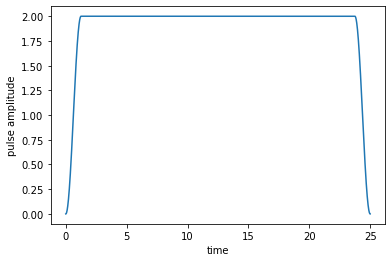

In [17]:
plot_pulse(L[1][1], tlist)

In [23]:
psi00 = qutip.Qobj(np.kron(np.array([1,0]), np.array([1,0])))
psi01 = qutip.Qobj(np.kron(np.array([1,0]), np.array([0,1])))
psi10 = qutip.Qobj(np.kron(np.array([0,1]), np.array([1,0])))
psi11 = qutip.Qobj(np.kron(np.array([0,1]), np.array([0,1])))
proj_00 = qutip.ket2dm(psi00)
proj_01 = qutip.ket2dm(psi01)
proj_10 = qutip.ket2dm(psi10)
proj_11 = qutip.ket2dm(psi11)

In [24]:
guess_dynamics = objectives[0].mesolve(
    tlist, e_ops=[proj_00, proj_01, proj_10, proj_11]
)

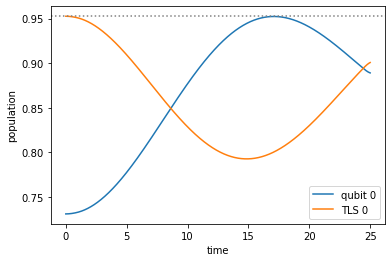

In [25]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(
        result.times,
        np.array(result.expect[0]) + np.array(result.expect[1]),
        label='qubit 0',
    )
    ax.plot(
        result.times,
        np.array(result.expect[0]) + np.array(result.expect[2]),
        label='TLS 0',
    )
    p0_TLS_init = np.array(result.expect[0][0]) + np.array(result.expect[2][0])
    ax.legend()
    ax.axhline(p0_TLS_init, ls=":", c='gray')
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)


plot_population(guess_dynamics)

## Optimize

In [26]:
def print_qubit_error(**args):
    """Utility function writing the qubit error to screen"""
    taus = []
    for state_T in args['fw_states_T']:
        state_q_T = trace_TLS(state_T)
        taus.append(state_q_T[0, 0].real)
    J_T = 1 - np.average(taus)
    print("    qubit error: %.1e" % J_T)
    return J_T


In [27]:
def chis_qubit(fw_states_T, objectives, tau_vals):
    """Calculate chis for the chosen functional"""
    chis = []
    for state_i_T in fw_states_T:
        chi_i = qutip.Qobj(np.kron(rho_q_trg, np.diag([1, 1])))
        chis.append(chi_i)
    return chis

In [28]:
opt_result = krotov.optimize_pulses(
    objectives,
    pulse_options,
    tlist,
    propagator=krotov.propagators.DensityMatrixODEPropagator(
        atol=1e-10, rtol=1e-8
    ),
    chi_constructor=chis_qubit,
    info_hook=krotov.info_hooks.chain(
        krotov.info_hooks.print_debug_information, print_qubit_error
    ),
    check_convergence=krotov.convergence.check_monotonic_error,
    iter_stop=5,
)


Iteration 0
    objectives:
        1:ρ₀[4,4] to ρ₁[4,4] via [𝓛₀[[4,4],[4,4]], [𝓛₁[[4,4],[4,4]], u₂(t)]]
    adjoint objectives:
        1:ρ₂[4,4] to ρ₃[4,4] via [𝓛₂[[4,4],[4,4]], [𝓛₃[[4,4],[4,4]], u₂(t)]]
    chi_constructor: chis_qubit
    mu: derivative_wrt_pulse
    S(t) (ranges): [0.000000, 1.000000]
    iter_start: 0
    iter_stop: 5
    duration: 0.2 secs (started at 2022-03-24 13:23:56)
    optimized pulses (ranges): [0.00, 2.00]
    ∫gₐ(t)dt: 0.00e+00
    λₐ: 1.00e-01
    storage (bw, fw, fw0): None, None, None
    fw_states_T norm: 1.000000
    τ: (7.97e-01:0.00π)
    qubit error: 1.1e-01
Iteration 1
    duration: 1.5 secs (started at 2022-03-24 13:23:56)
    optimized pulses (ranges): [0.00, 2.06]
    ∫gₐ(t)dt: 8.55e-02
    λₐ: 1.00e-01
    storage (bw, fw, fw0): [1 * ndarray(2500)] (1.2 MB), None, None
    fw_states_T norm: 1.000000
    τ: (7.98e-01:0.00π)
    qubit error: 1.0e-01
Iteration 2
    duration: 1.6 secs (started at 2022-03-24 13:23:58)
    optimized pulses (rang

In [29]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2022-03-24 13:23:56
- Number of objectives: 1
- Number of iterations: 5
- Reason for termination: Reached 5 iterations
- Ended at 2022-03-24 13:24:04 (0:00:08)

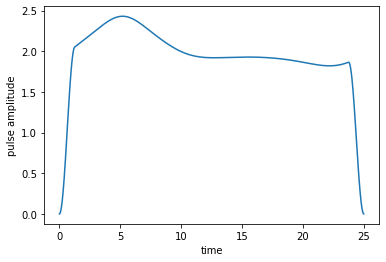

In [30]:
plot_pulse(opt_result.optimized_controls[0], tlist)

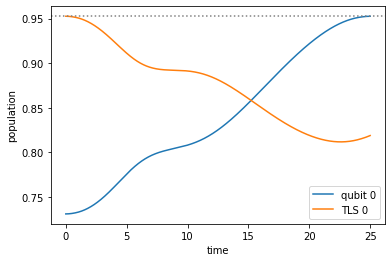

In [31]:
optimized_dynamics = opt_result.optimized_objectives[0].mesolve(
    tlist, e_ops=[proj_00, proj_01, proj_10, proj_11]
)

plot_population(optimized_dynamics)


In [33]:
propagator=krotov.propagators.DensityMatrixODEPropagator(atol=1e-10, rtol=1e-8)

In [36]:
propagator(L, proj_00, 0.01)

TypeError: 'NoneType' object is not iterable

In [39]:
dt

NameError: name 'dt' is not defined

In [40]:
L

[Quantum object: dims = [[[4], [4]], [[4], [4]]], shape = (16, 16), type = super, isherm = False
 Qobj data =
 [[-0.00209583+0.j   0.        +0.j   0.        +0.j   0.        +0.j
    0.        +0.j   0.04209583+0.j   0.        +0.j   0.        +0.j
    0.        +0.j   0.        +0.j   0.        +0.j   0.        +0.j
    0.        +0.j   0.        +0.j   0.        +0.j   0.        +0.j ]
  [ 0.        +0.j  -0.02209583-3.j   0.        -0.1j  0.        +0.j
    0.        +0.j   0.        +0.j   0.        +0.j   0.        +0.j
    0.        +0.j   0.        +0.j   0.        +0.j   0.        +0.j
    0.        +0.j   0.        +0.j   0.        +0.j   0.        +0.j ]
  [ 0.        +0.j   0.        -0.1j -0.00209583-1.j   0.        +0.j
    0.        +0.j   0.        +0.j   0.        +0.j   0.04209583+0.j
    0.        +0.j   0.        +0.j   0.        +0.j   0.        +0.j
    0.        +0.j   0.        +0.j   0.        +0.j   0.        +0.j ]
  [ 0.        +0.j   0.        +0.j   0.    

In [41]:
import inspect

In [42]:
inspect.getfullargspec(krotov.propagators.expm)

FullArgSpec(args=['H', 'state', 'dt', 'c_ops', 'backwards', 'initialize'], varargs=None, varkw=None, defaults=(None, False, False), kwonlyargs=[], kwonlydefaults=None, annotations={})